In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from keras.models import *
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

import keras
import keras.callbacks
import tensorflow as tf
import numpy as np
import pandas as pd
import imblearn

import gensim.downloader as api
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re

In [ ]:
wv = api.load('word2vec-google-news-300')

In [ ]:
wv.save_word2vec_format('/kaggle/working/GoogleNews-vectors-negative300.txt', binary=False)

In [2]:
def preprocess(text):
  
  text=text.lower()
  text=re.sub(r'rt\s*@[^:]*:\s', ' ', text)
  text=re.sub(r'[^A-Za-z0-9]+', ' ', text)
  text=re.sub(r' t .*$', '', text)
  text=re.sub(r'\b[a-zA-Z]\b', '', text)
  text=re.sub(r'/^\s+|\s+$|\s+(?=\s)/g', '', text);
  text = re.sub(r's+[a-zA-Z]s+', '', text)
  text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
  text=re.sub(r'https?','',text)
  text=re.sub(r'#[A-Za-z0-9_]+','',text)
  text=re.sub(r'\.\.\.',' ',text)
  text=text.replace('…',' ')
  text=text.replace('..',' ')
  text=re.sub(r'@\w*',r'',text)
  text=re.sub(r'\s{2,}',r' ',text)
  text=re.sub(r'$[\s]+','',text)
  text=text.replace('&amp','')
  text=text.replace('&gt','')
  text=text.replace('&lt','')
  text=re.sub(r'([\w\d]+)([^\w\d ]+)', r'\1 \2',text)
  text=re.sub(r'([^\w\d ]+)([\w\d]+)', r'\1 \2',text)
 
  return text

In [3]:
train = pd.read_csv('/kaggle/input/dataset/train.csv', index_col = 0)
del(train["tweet_id"])
del(train["image_id"])
del(train["image_path"])
del(train["text_info_conf"])
del(train["image_info"])
del(train["image_info_conf"])
del(train["text_human"])
del(train["text_human_conf"])
del(train["image_human"])
del(train["image_human_conf"])
del(train["image_damage"])
del(train["image_damage_conf"])
del(train["image_url"])
del(train["Unnamed: 0.1"])

train["tweet_text"]=train["tweet_text"].apply(lambda x: preprocess(x))
train["type"] = train["text_info"].apply(lambda x: 1 if x == "informative"  else 0)

train

,text_info,tweet_text,type
15380,informative,irma creates bittersweet travel bonus for luck...,1
12344,informative,hurricane irma orange county mayor jacobs str...,1
15867,informative,tax help for busine hit by harvey and irma can...,1
9291,informative,miranda lambert amp chris stapleton to join ge...,1
10180,not_informative,hurricane blame harvey amp irma punishment for...,0
...,...,...,...
10536,informative,list of the greatest storms harvey irma katri...,1
7227,informative,more photos earthquake at kurdistan photos be...,1
13854,informative,money irma cnnpolitics republicans aren,1
8948,not_informative,you can spot my short ass behind all the trash...,0


In [4]:
test = pd.read_csv('/kaggle/input/dataset/test.csv', index_col = 0)
del(test["tweet_id"])
del(test["image_id"])
del(test["image_path"])
del(test["text_info_conf"])
del(test["image_info"])
del(test["image_info_conf"])
del(test["text_human"])
del(test["text_human_conf"])
del(test["image_human"])
del(test["image_human_conf"])
del(test["image_damage"])
del(test["image_damage_conf"])
del(test["image_url"])
del(test["Unnamed: 0.1"])

test["tweet_text"]=test["tweet_text"].apply(lambda x: preprocess(x))
test["type"] = test["text_info"].apply(lambda x: 1 if x == "informative"  else 0)

test 


,text_info,tweet_text,type
586,not_informative,incredible moment family dog emerges unscathed...,0
5116,informative,it may be dark in puerto rico but electric cus...,1
4549,not_informative,comic diary about what we re living in puertor...,0
15254,not_informative,enjoy your first night after irma with no curfew,0
1691,informative,bangladesh has evacuated at least 350 000 peo...,1
...,...,...,...
17618,informative,4 00 magnitude earthquake has occurred near o...,1
8818,informative,some of texas most selfless hurricane harvey h...,1
12462,informative,irma destruction island by island,1
11417,not_informative,making difference back in my hometown hurrican...,0


In [5]:
max_len = 50
len_voc = 40000

In [6]:
def make_tokenizer(texts, len_voc):
    from keras.preprocessing.text import Tokenizer
    t = Tokenizer(num_words=len_voc)
    t.fit_on_texts(texts)
    return t

In [7]:
tokenizer = make_tokenizer(train['tweet_text'], len_voc)

In [8]:
X_train = tokenizer.texts_to_sequences(train['tweet_text'])
X_test = tokenizer.texts_to_sequences(test['tweet_text'])

In [9]:
X_train = pad_sequences(X_train, maxlen=max_len, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_len, padding='post', truncating='post')

In [10]:
y_train = train['type'].values
y_test = test['type'].values

In [11]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')

def load_embedding(file):
    if file == './GoogleNews-vectors-negative300.txt':
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file) if len(o)>100)
    else:
        embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(file, encoding='latin'))
    return embeddings_index

In [12]:
def make_embedding_matrix(embedding, tokenizer, len_voc):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    word_index = tokenizer.word_index
    embedding_matrix = np.random.normal(emb_mean, emb_std, (len_voc, embed_size))
    
    for word, i in word_index.items():
        if i >= len_voc:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [13]:
w2v = load_embedding('./GoogleNews-vectors-negative300.txt')

In [14]:
len(w2v)

3000000

In [15]:
w2v = dict(itertools.islice(w2v.items(), 500000)) 

In [16]:
len(w2v)

500000

In [17]:
embed_mat = make_embedding_matrix(w2v, tokenizer, len_voc)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
X_train_emb = embed_mat[X_train]
X_test_emb = embed_mat[X_test]

In [19]:
train_size, max_len, embed_size = X_train_emb.shape
X_train_emb_r = X_train_emb.reshape(train_size, max_len*embed_size)

In [20]:
X_train_emb_r.shape

(14465, 15000)

In [21]:
smt = SMOTE(sampling_strategy = 'minority')
X_smote, y_smote = smt.fit_resample(X_train_emb_r, y_train)

In [22]:
X_smote = X_smote.reshape((X_smote.shape[0], max_len, embed_size))

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


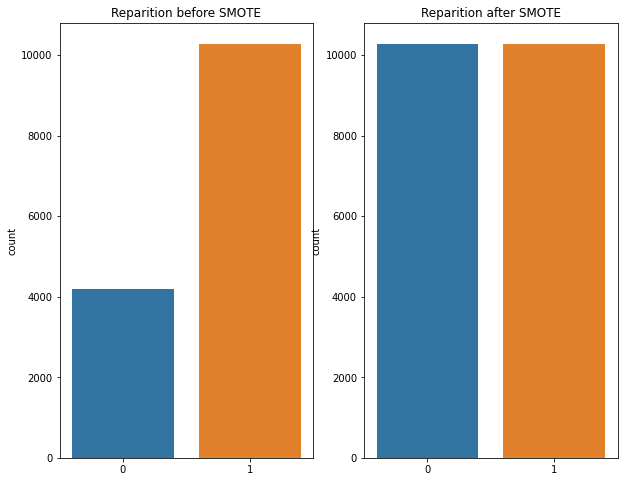

In [23]:
plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
sns.countplot(y_train)
plt.title('Reparition before SMOTE')
plt.subplot(1, 2, 2)
sns.countplot(y_smote)
plt.title('Reparition after SMOTE')
plt.show()

In [24]:
def make_model(max_len, len_voc=50000, embed_size=300):
    inp = tf.keras.Input(shape=(max_len, 300))
    x = GRU(32, return_sequences = True)(inp)
    x = GlobalMaxPool1D()(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])
    return model

In [25]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)  
mc = keras.callbacks.ModelCheckpoint('/kaggle/working/w2v_best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose =1)

In [26]:
model_smote = make_model(max_len)

2022-05-08 15:21:05.741341: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 15:21:05.843219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 15:21:05.843972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-08 15:21:05.846606: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [27]:
model_smote.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 300)]         0         
_________________________________________________________________
gru (GRU)                    (None, 50, 32)            32064     
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 32,097
Trainable params: 32,097
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model_smote.fit(X_smote, y_smote, 
                batch_size=128, 
                epochs=50, 
                validation_data=(X_test_emb, y_test), 
                callbacks=[es, mc])

2022-05-08 15:21:40.129864: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1234080000 exceeds 10% of free system memory.
2022-05-08 15:21:41.423711: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1234080000 exceeds 10% of free system memory.
2022-05-08 15:21:42.584299: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-05-08 15:21:45.256658: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


161/161 [==============================] - 6s 13ms/step - loss: 0.4099 - accuracy: 0.8122 - val_loss: 0.4683 - val_accuracy: 0.7736

Epoch 00001: val_loss improved from inf to 0.46834, saving model to /kaggle/working/w2v_best_model.h5
Epoch 2/50
161/161 [==============================] - 2s 9ms/step - loss: 0.3138 - accuracy: 0.8635 - val_loss: 0.4054 - val_accuracy: 0.8264

Epoch 00002: val_loss improved from 0.46834 to 0.40539, saving model to /kaggle/working/w2v_best_model.h5
Epoch 3/50
161/161 [==============================] - 2s 9ms/step - loss: 0.2446 - accuracy: 0.8984 - val_loss: 0.4239 - val_accuracy: 0.8186

Epoch 00003: val_loss did not improve from 0.40539
Epoch 4/50
161/161 [==============================] - 2s 9ms/step - loss: 0.1915 - accuracy: 0.9239 - val_loss: 0.4444 - val_accuracy: 0.8308

Epoch 00004: val_loss did not improve from 0.40539
Epoch 5/50
161/161 [==============================] - 1s 9ms/step - loss: 0.1448 - accuracy: 0.9437 - val_loss: 0.4947 - val_acc

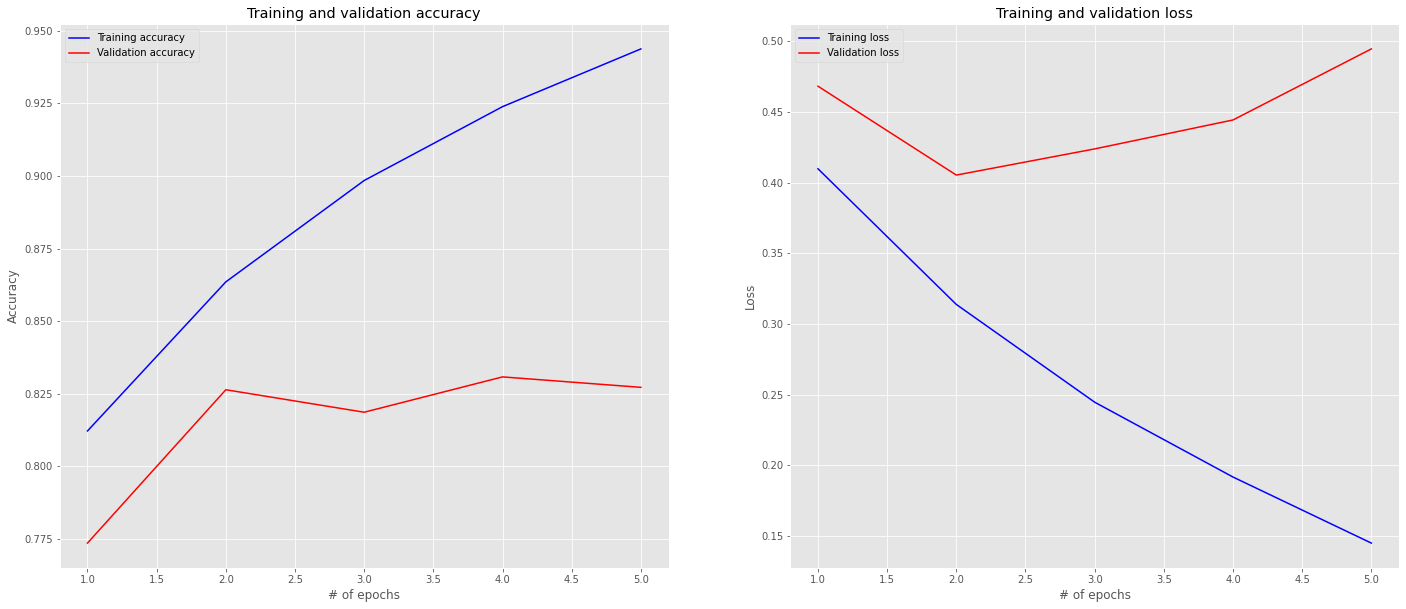

In [29]:
plt.style.use('ggplot')

def plot_history(model_smote):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 10))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('# of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('# of epochs')
    plt.ylabel('Loss')
    plt.legend()

plot_history(model_smote)

In [30]:
y_pred = model_smote.predict(X_test_emb)

y_pred_hot = []
for i in range(len(y_pred)):
  if (y_pred[i] < 0.5):
    y_pred_hot.append(0)
  else:
    y_pred_hot.append(1)

In [31]:
cm = confusion_matrix(y_test, y_pred_hot)
cr = classification_report(y_test, y_pred_hot)

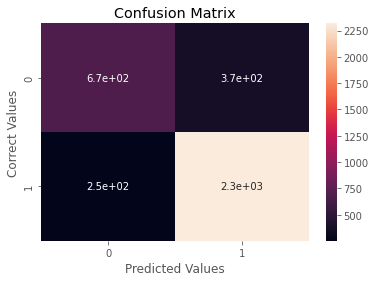


              precision    recall  f1-score   support

           0       0.73      0.64      0.68      1046
           1       0.86      0.90      0.88      2571

    accuracy                           0.83      3617
   macro avg       0.79      0.77      0.78      3617
weighted avg       0.82      0.83      0.82      3617



In [32]:
sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.ylabel('Correct Values')
plt.xlabel('Predicted Values')
plt.show()
print()
print(cr)